In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/csc2515-rating-prediction

/content/drive/MyDrive/csc2515-rating-prediction


In [3]:
import nltk
nltk.download('popular')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [4]:
import sklearn
import pandas as pd
import re
import numpy as np

In [5]:
!pip install ipython-autotime

%load_ext autotime

time: 158 µs


In [6]:
# df = pd.read_csv("data.csv", sep = "\t")

df_train = pd.read_csv("train.csv")
# df_test = pd.read_csv("test.csv")
df_train.head()

,Unnamed: 0,id,update_date,author,title,abstract,categories,journal,versions,doi,general_category,countWordsAbs,author_clean
0,256809,nlin/0501049,2009-09-29,['hua shu dou'],Energy Gradient Theory of Hydrodynamic Instabi...,A new universal theory for flow instability ...,nlin.CD,NaN,"[{'version': 'v1', 'created': 'Fri, 28 Jan 200...",NaN,nlin,241,hua shu dou
1,45953,810.3364,2009-05-18,['v e rochev'],Properties of predictive formulation of the Na...,"Recently proposed by Battistel et al. ""predi...",hep-th,"J.Phys.A42:195403,2009","[{'version': 'v1', 'created': 'Sun, 19 Oct 200...",10.1088/1751-8113/42/19/195403,hep-th,59,v e rochev
2,7783,707.137,2008-11-26,"['k s kim', 'b g yu', 'm k cheoun', 't ...",Neutral-current Neutrino-nucleus Scattering in...,The neutral-current neutrino-nucleus scatter...,nucl-th,"J.Phys.G34:2643-2654,2007","[{'version': 'v1', 'created': 'Tue, 10 Jul 200...",10.1088/0954-3899/34/12/009,nucl-th,103,"k s kim,b g yu,m k cheoun,t k choi,m ..."
3,79035,astro-ph/0203101,2008-11-26,"['markus rampp', 'h thomas janka']",Radiation hydrodynamics with neutrinos: Variab...,Neutrino transport and neutrino interactions...,astro-ph,"Astron.Astrophys.396:361,2002","[{'version': 'v1', 'created': 'Thu, 7 Mar 2002...",10.1051/0004-6361:20021398,astro-ph,273,"markus rampp,h thomas janka"
4,253601,math/9809152,2007-05-23,['michael frank'],Normal conditional expectations of finite inde...,Normal conditional expectations E: M --> N i...,math.OA,NaN,"[{'version': 'v1', 'created': 'Sat, 26 Sep 199...",NaN,math,164,michael frank


time: 5.92 s


In [7]:
df_train["trainingText"] = df_train['title']+df_train['abstract']+df_train['author_clean']
# df_test['column'] = df_test['title'] + df_test['abstract']

time: 458 ms


Exploratory Data Analysis

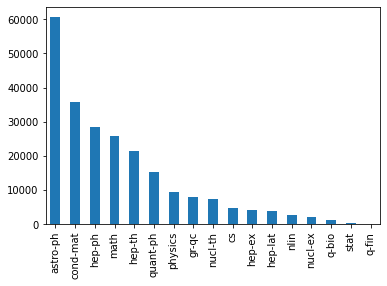

time: 281 ms


In [9]:
# Number of different categories
df_train['general_category'].value_counts()[:17].plot.bar()

Data Preprocessing

In [10]:
# def, get_clean, (, x, )
def get_clean(x):
    # Remove all characters not in the English alphabet
    x = re.sub("[^a-zA-Z]"," ", str(x))
    x = str(x).lower()
    x = re.sub(r'\s+', ' ',x).strip()
    return x

time: 2.41 ms


In [11]:
df_train["trainingText"] = df_train["trainingText"].apply(lambda x: get_clean(x))
# df_test['clean_abstract'] = df_test['column'].apply(data_cleaning)

time: 18.1 s


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, max_df=1.0, min_df=1, ngram_range=(1,3)):
    m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    d = m.fit_transform(data)
    return m, d

tfidf_m, tfidf_d = get_tf(df_train["trainingText"], max_df=0.90, min_df=10)
n_topics = 17

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


time: 8min 48s


In [14]:
from sklearn.linear_model import LogisticRegression

allcats = sorted(list(set(df_train['general_category'])))
def binLR(x, y):
    models = []
    for c in allcats:
        y_adj = np.array(y==c)
        lm = LogisticRegression(max_iter=5000, solver = "newton-cg")
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = binLR(tfidf_d, df_train['general_category'])

time: 11min 19s


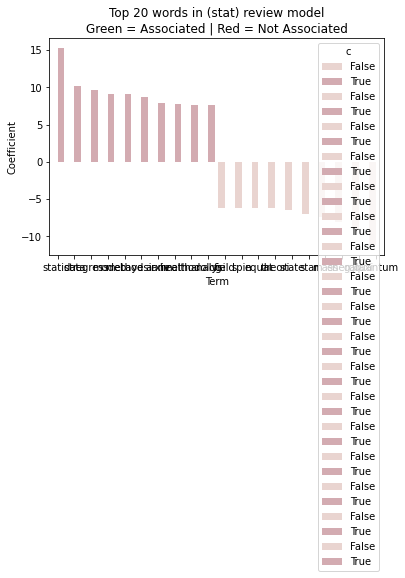

time: 24.4 s


In [15]:
%matplotlib inline
import seaborn as sns

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    # f = open('arxiv_keywords.txt', 'a')
    # f.write('Category\n\n{}\n\nKeywords\n\n{}\n\n\n'.format(topic, df))
    # f.close()
    colr = sns.cubehelix_palette()
    ax = sns.barplot(data = df, x='Term', y='Coefficient', hue = "c",palette=colr).set_title(title)

allcats
n_terms = 10
for c in range(17):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=allcats[c]), 
              lr_m[c], tfidf_m.get_feature_names(), n_terms)

In [16]:
def topFeature(text, category, n):
  ''' Return the top features given a category'''
  vectorizer = TfidfVectorizer()
  df = text.head(10000)
  df = df.loc[df['general_category'] == category]
  X = vectorizer.fit_transform(df['trainingText'])
  return X.toarray().min()

time: 3.49 ms


In [17]:
topFeature(df_train, 'astro-ph', 20)

0.0

time: 550 ms


In [19]:
print((lr_m[0].coef_))

[[ 1.16433226  0.19253121  0.03855286 ... -0.01625947 -0.00620856
  -0.01319636]]
time: 2.48 ms


In [20]:
df_train.groupby('general_category').count()

,Unnamed: 0,id,update_date,author,title,abstract,categories,journal,versions,doi,countWordsAbs,author_clean,trainingText
general_category,,,,,,,,,,,,,
astro-ph,60616,60616,60616,60616,60616,60616,60616,25761,60616,43885,60616,60616,60616
cond-mat,35905,35905,35905,35905,35905,35905,35905,17108,35905,27593,35905,35905,35905
cs,4762,4762,4762,4762,4762,4762,4762,1753,4762,227,4762,4762,4762
gr-qc,8118,8118,8118,8118,8118,8118,8118,5438,8118,5020,8118,8118,8118
hep-ex,4100,4100,4100,4100,4100,4100,4100,1972,4100,1889,4100,4100,4100
hep-lat,3823,3823,3823,3823,3823,3823,3823,2965,3823,2749,3823,3823,3823
hep-ph,28507,28507,28507,28507,28507,28507,28507,18662,28507,18180,28507,28507,28507
hep-th,21318,21318,21318,21318,21318,21318,21318,15768,21318,15259,21318,21318,21318
math,25895,25895,25895,25895,25895,25895,25895,4940,25895,2013,25895,25895,25895


time: 457 ms
